In [1]:
%pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 7.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.7 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset("martingrzzler/radicals")

Generating train split: 0 examples [00:00, ? examples/s]

Dataset radicals downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___radicals/default/0.0.0/d06fa45bbf364a018a5727e22360769bec2306739b86877c63d2734b6fad32e7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
ds['train'].features

{'radical_image': Image(decode=True, id=None),
 'meta': {'id': Value(dtype='int32', id=None),
  'characters': Value(dtype='string', id=None),
  'slug': Value(dtype='string', id=None)}}

In [4]:
radical_ids = set()
for meta in ds['train']['meta']:
    radical_ids.add(meta['id'])

unique_radical_ids = sorted(list(radical_ids))
num_classes = len(unique_radical_ids)
radical_id_to_index = {radical_id: idx for idx, radical_id in enumerate(unique_radical_ids)}

In [5]:
import numpy as np

def set_label(example):
    return {"label": radical_id_to_index[example['meta']['id']]}

In [6]:
ds_labeled = ds.map(set_label)

Map:   0%|          | 0/21950 [00:00<?, ? examples/s]

In [109]:
# sort ds_labeld by label
ds_labeled = ds_labeled.sort('label')

In [110]:
ds_train = ds_labeled.remove_columns(["meta"])

In [111]:
resized_ds = ds_train.map(lambda example: {"radical_image": example['radical_image'].resize((64, 64))})

Map:   0%|          | 0/21950 [00:00<?, ? examples/s]

In [112]:
import random
import numpy as np
import torch

def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(107648, 128)
        self.fc2 = nn.Linear(128, num_classes)

               # Custom weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net(num_classes)

In [115]:
resized_ds.set_format(type='torch', columns=['radical_image', 'label'])

In [116]:
normalized_ds = resized_ds.map(lambda example: {"radical_image": example['radical_image'].unsqueeze(0) / 255.0})

Map:   0%|          | 0/21950 [00:00<?, ? examples/s]

In [117]:
first_half_ds = normalized_ds['train'].select(range(len(normalized_ds['train']) // 2))
second_half_ds = normalized_ds['train'].select(range(len(normalized_ds['train']) // 2, len(normalized_ds['train'])))

In [91]:
import matplotlib.pyplot as plt

tensor(0)


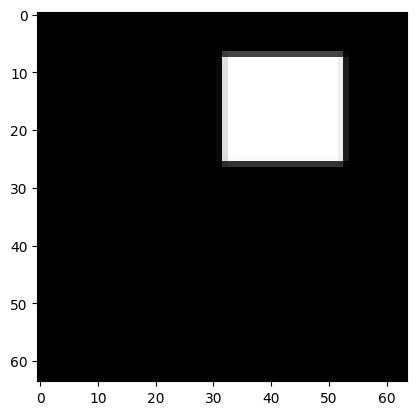

In [119]:
print(first_half_ds[0]['label'])
plt.imshow(first_half_ds[0]['radical_image'].squeeze(0), cmap='gray')

In [130]:
splits = normalized_ds['train'].train_test_split(test_size=0.1, shuffle=True)

In [150]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(splits['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(splits['test'], batch_size=batch_size)

In [151]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=.00001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [124]:
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=107648, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=439, bias=True)
)

In [152]:
losses = []
best_state = None
best_loss = 10000

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for idx, batch in enumerate(train_loader):
        images, labels = batch['radical_image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.nll_loss(outputs, labels)
        losses.append(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if idx % 2 == 0:
            if loss < best_loss:
                best_state = model.state_dict()
                best_loss = loss
            print(f"Epoch {epoch+1}/{num_epochs}, Step {idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['radical_image'].to(device), batch['label'].to(device)
            outputs = model(images)
            loss = F.nll_loss(outputs, labels)
            test_loss += loss.item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
        print(f"Epoch {epoch+1}/{num_epochs}, Accuracy:{correct / len(test_loader.dataset) * 100}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {test_loss/len(test_loader)}")

Epoch 1/15, Step 1/1235, Loss: 1.6489685773849487
Epoch 1/15, Step 3/1235, Loss: 0.9151447415351868
Epoch 1/15, Step 5/1235, Loss: 1.3916609287261963
Epoch 1/15, Step 7/1235, Loss: 0.9256405830383301
Epoch 1/15, Step 9/1235, Loss: 1.6245784759521484
Epoch 1/15, Step 11/1235, Loss: 1.175554871559143
Epoch 1/15, Step 13/1235, Loss: 1.6932106018066406
Epoch 1/15, Step 15/1235, Loss: 1.357836365699768
Epoch 1/15, Step 17/1235, Loss: 0.7321809530258179
Epoch 1/15, Step 19/1235, Loss: 1.7160745859146118
Epoch 1/15, Step 21/1235, Loss: 0.8655218482017517
Epoch 1/15, Step 23/1235, Loss: 0.9092077612876892
Epoch 1/15, Step 25/1235, Loss: 1.5549523830413818
Epoch 1/15, Step 27/1235, Loss: 1.1434868574142456
Epoch 1/15, Step 29/1235, Loss: 0.6349091529846191
Epoch 1/15, Step 31/1235, Loss: 1.3582205772399902
Epoch 1/15, Step 33/1235, Loss: 0.9320374727249146
Epoch 1/15, Step 35/1235, Loss: 1.2687275409698486
Epoch 1/15, Step 37/1235, Loss: 1.0976359844207764
Epoch 1/15, Step 39/1235, Loss: 1.1844

KeyboardInterrupt: 

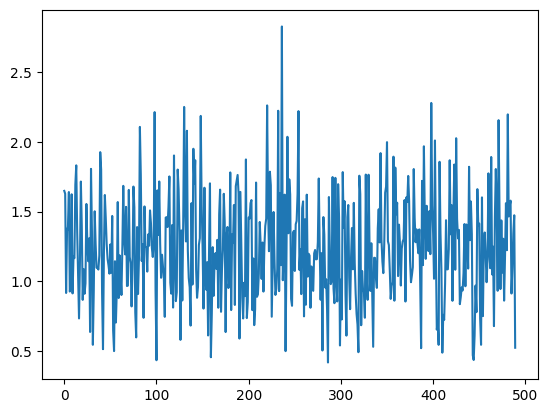

In [154]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [127]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [137]:
save_model(model, "v1.pt")

In [157]:
best_model = Net(num_classes)
best_model.load_state_dict(best_state)
best_model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=107648, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=439, bias=True)
)

In [158]:
best_model.eval()
correct = 0
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['radical_image'].to(device), batch['label'].to(device)
        outputs = best_model(images)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
    print(f"Accuracy: {correct}/{len(test_loader.dataset)} -  {correct / len(test_loader.dataset) * 100}")

Accuracy: 1697/2195 -  77.3120728929385


In [162]:
save_model(best_model, "v1_best.pt")

Label: 20, Prediction: 20


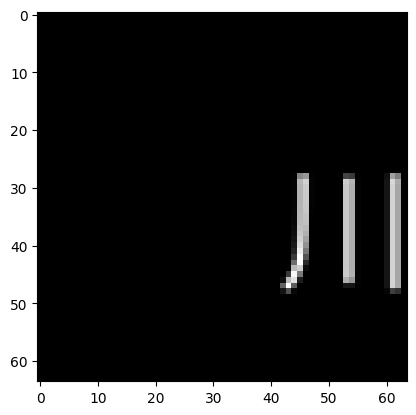

Label: 317, Prediction: 317


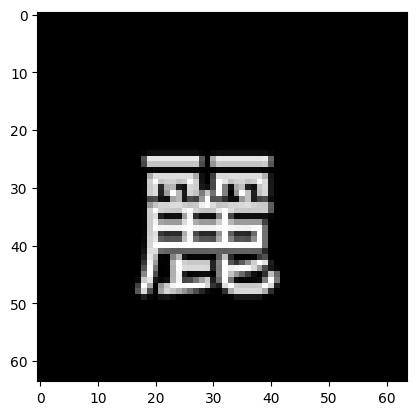

Label: 378, Prediction: 378


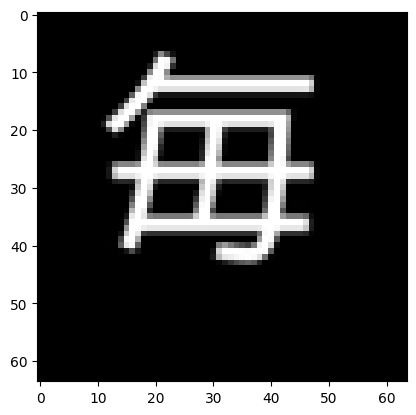

Label: 293, Prediction: 187


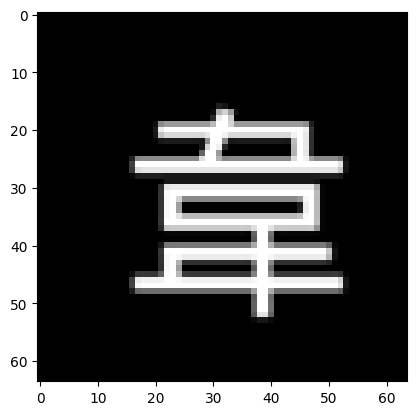

Label: 261, Prediction: 261


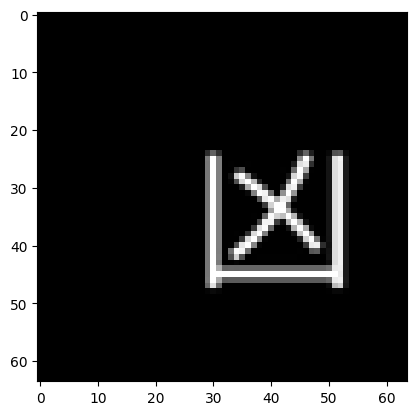

Label: 204, Prediction: 204


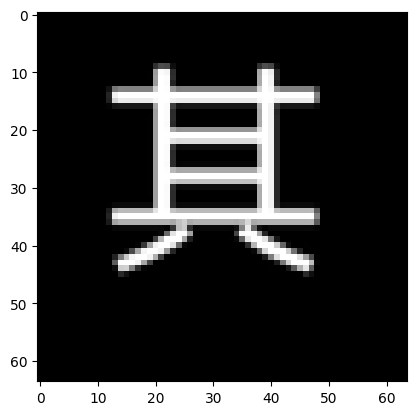

Label: 30, Prediction: 30


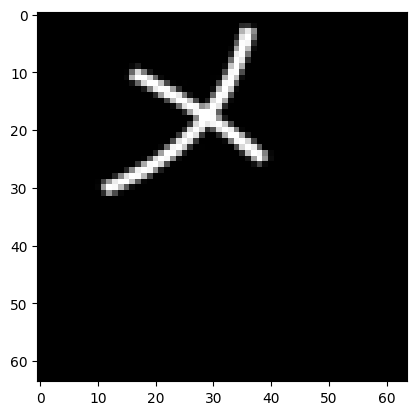

Label: 79, Prediction: 79


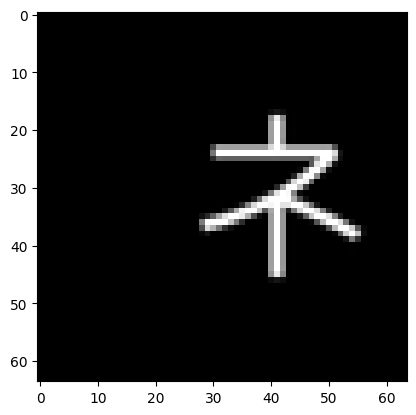

Label: 52, Prediction: 108


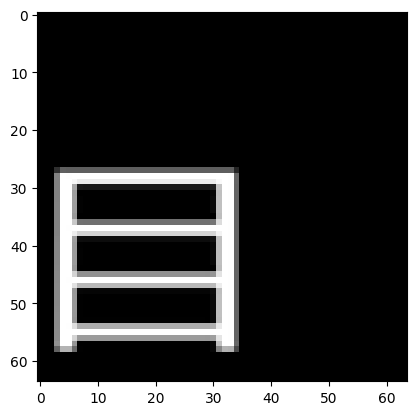

Label: 261, Prediction: 261


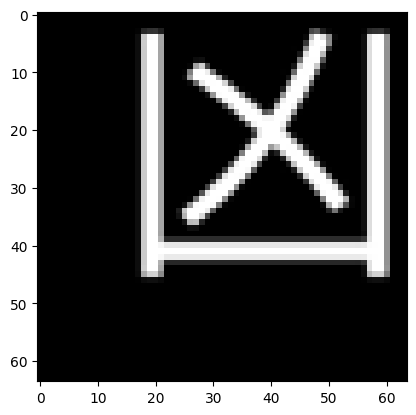

In [161]:
import random

for i in range(10):
    random_idx = random.randint(0, len(test_loader.dataset))

    example = test_loader.dataset[random_idx]
    image = example['radical_image'].unsqueeze(0).to(device)
    output = best_model(image)
    pred = output.argmax(dim=1, keepdim=True)
    print(f"Label: {example['label']}, Prediction: {pred.item()}")
    plt.imshow(example['radical_image'].squeeze(0).cpu(), cmap='gray')
    plt.show()